# Notebook for binary data preparation

In [22]:
import pandas as pd
import numpy as np

In [23]:
import os
def list_files_recursive(files, path='.'):
    for entry in os.listdir(path):
        full_path = os.path.join(path, entry)
        if os.path.isdir(full_path):
            list_files_recursive(files, full_path)
        else:
            files.append(full_path)

In [24]:
import re 
file_names = []
list_files_recursive(file_names, '../data/raw')

whole_df = pd.DataFrame()
for file_name in file_names:
    if file_name.endswith('.svc'):
        user = file_name.split('/')[-3]
        session = file_name.split('/')[-2]
        df = pd.read_csv(file_name,  delimiter=r"\s+", skiprows=[0], header=None)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'azimuth', 'altitude', 'pressure']
        df['user'] = user
        df['session'] = session
        df['collection'] = file_name.split('../data/raw/')[1].split('/')[0]
        homework_as_text = file_name.split('../data/raw/')[1].split('_')[1][:-4]
        match = re.search(r'\d+', homework_as_text)
        df['homework'] = int(match.group())
        
        whole_df = pd.concat([whole_df, df], axis=0)


In [25]:
labels_df = pd.read_excel('../data/raw/DASS_scores.xls')

In [26]:
labels_df['id'] = labels_df['Directory'] + labels_df['File Number user'].apply(lambda x: 'user' + str(x).rjust(5, '0'))

In [27]:
whole_df['id'] = whole_df['collection'] + whole_df['user']

In [28]:
whole_df.head()

,x,y,timestamp,pen_status,azimuth,altitude,pressure,user,session,collection,homework,id
0,51121,34662,1992990,1,1800,530,1,user00015,session00001,Collection2,1,Collection2user00015
1,51143,34656,1992997,1,1800,530,24,user00015,session00001,Collection2,1,Collection2user00015
2,51151,34653,1993005,1,1800,530,44,user00015,session00001,Collection2,1,Collection2user00015
3,51158,34651,1993012,1,1800,530,57,user00015,session00001,Collection2,1,Collection2user00015
4,51163,34649,1993020,1,1800,530,67,user00015,session00001,Collection2,1,Collection2user00015


In [29]:
labels_df.head()
labels_df.rename(columns={'Suject': 'Subject'}, inplace=True)


In [30]:
labeled_data = pd.merge(whole_df, labels_df, how='inner', on='id')

In [31]:
labeled_data.head()

,x,y,timestamp,pen_status,azimuth,altitude,pressure,user,session,collection,homework,id,Subject,depression,anxiety,stress,Database Collectors,File Number user,Directory
0,51121,34662,1992990,1,1800,530,1,user00015,session00001,Collection2,1,Collection2user00015,60,4,3,6,"Franzese, Apicella, Ferrucci",15,Collection2
1,51143,34656,1992997,1,1800,530,24,user00015,session00001,Collection2,1,Collection2user00015,60,4,3,6,"Franzese, Apicella, Ferrucci",15,Collection2
2,51151,34653,1993005,1,1800,530,44,user00015,session00001,Collection2,1,Collection2user00015,60,4,3,6,"Franzese, Apicella, Ferrucci",15,Collection2
3,51158,34651,1993012,1,1800,530,57,user00015,session00001,Collection2,1,Collection2user00015,60,4,3,6,"Franzese, Apicella, Ferrucci",15,Collection2
4,51163,34649,1993020,1,1800,530,67,user00015,session00001,Collection2,1,Collection2user00015,60,4,3,6,"Franzese, Apicella, Ferrucci",15,Collection2


In [32]:
labeled_data.drop(['Directory', 'File Number user', 'session', 'collection', 'id', 'Database Collectors', 'Directory', 'user'], axis=1, inplace=True)

In [33]:
labeled_data.head()

,x,y,timestamp,pen_status,azimuth,altitude,pressure,homework,Subject,depression,anxiety,stress
0,51121,34662,1992990,1,1800,530,1,1,60,4,3,6
1,51143,34656,1992997,1,1800,530,24,1,60,4,3,6
2,51151,34653,1993005,1,1800,530,44,1,60,4,3,6
3,51158,34651,1993012,1,1800,530,57,1,60,4,3,6
4,51163,34649,1993020,1,1800,530,67,1,60,4,3,6


In [34]:
labeled_data[labeled_data['Subject']==1]

,x,y,timestamp,pen_status,azimuth,altitude,pressure,homework,Subject,depression,anxiety,stress
2080643,34566,36143,724770,1,1820,590,212,3,1,2,8,13
2080644,34546,36112,724777,1,1820,600,314,3,1,2,8,13
2080645,34492,36097,724785,1,1820,600,388,3,1,2,8,13
2080646,34412,36081,724792,1,1820,600,473,3,1,2,8,13
2080647,34304,36065,724800,1,1820,600,523,3,1,2,8,13
...,...,...,...,...,...,...,...,...,...,...,...,...
2096600,6709,6953,875051,1,2210,690,852,7,1,2,8,13
2096601,6712,6914,875058,1,2210,690,838,7,1,2,8,13
2096602,6717,6872,875066,1,2190,700,793,7,1,2,8,13
2096603,6719,6837,875073,1,2190,700,703,7,1,2,8,13


In [35]:
labeled_data['depression'] = labeled_data['depression'] > 9
labeled_data['anxiety'] = labeled_data['anxiety'] > 7
labeled_data['stress'] = labeled_data['stress'] > 14

In [36]:
labeled_data.head()

,x,y,timestamp,pen_status,azimuth,altitude,pressure,homework,Subject,depression,anxiety,stress
0,51121,34662,1992990,1,1800,530,1,1,60,False,False,False
1,51143,34656,1992997,1,1800,530,24,1,60,False,False,False
2,51151,34653,1993005,1,1800,530,44,1,60,False,False,False
3,51158,34651,1993012,1,1800,530,57,1,60,False,False,False
4,51163,34649,1993020,1,1800,530,67,1,60,False,False,False


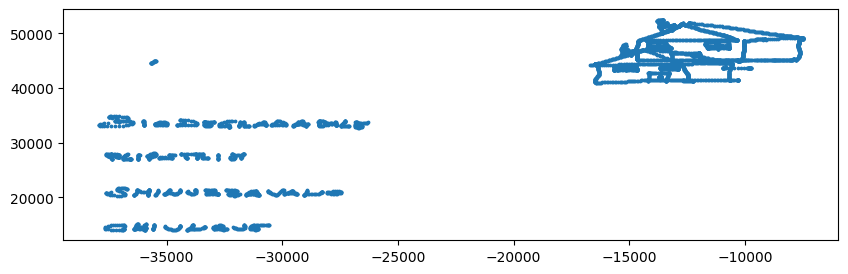

In [16]:
import matplotlib.pyplot as plt

labeled_data = pd.read_parquet('../data/raw_binary/labeled_data.parquet')
sample_subject_data = labeled_data[(labeled_data['pen_status']==1) & (labeled_data['homework']==0)]
plt.figure(figsize=(10,3))
plt.scatter(-sample_subject_data['y'], sample_subject_data['x'], s=3)


In [37]:
labeled_data.to_parquet('../data/raw_binary/labeled_data.parquet')

# Data re-organization

In [19]:
whole_df = whole_df.sort_values(by=["id", "timestamp"])

# Group by subject and aggregate x-position and y-position as lists
data_as_array_df = whole_df.groupby(["id", "homework", "pen_status"]).agg({
    "x": list,
    "y": list,
    "timestamp": list,
    "azimuth": list,
    "altitude": list,
    "pressure": list
}).reset_index()

In [20]:
data_as_array_df.head()

,id,homework,pen_status,x,y,timestamp,azimuth,altitude,pressure
0,Collection1user00001,1,0,"[48331, 48318, 48305, 48305, 48305, 48305, 483...","[31876, 31963, 32053, 32159, 32159, 32159, 321...","[672620, 672628, 672635, 672643, 672650, 67282...","[1830, 1830, 1830, 1830, 1830, 1830, 1830, 234...","[530, 530, 530, 530, 530, 530, 530, 350, 360, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Collection1user00001,1,1,"[47944, 47949, 47949, 47950, 47950, 47950, 479...","[33492, 33506, 33512, 33515, 33519, 33524, 335...","[671854, 671861, 671869, 671876, 671884, 67189...","[1800, 1800, 1800, 1800, 1800, 1810, 1810, 181...","[490, 500, 500, 500, 500, 500, 500, 500, 500, ...","[67, 148, 193, 228, 270, 306, 341, 365, 381, 3..."
2,Collection1user00001,2,0,"[41647, 41714, 41787, 41896, 41896, 41616, 416...","[14655, 14657, 14675, 14677, 14677, 15475, 154...","[692915, 692922, 692930, 692937, 692945, 69356...","[1830, 1830, 1830, 1840, 1840, 2530, 2530, 253...","[530, 530, 530, 530, 530, 450, 450, 450, 460, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Collection1user00001,2,1,"[45074, 45128, 45144, 45158, 45164, 45169, 451...","[14676, 14676, 14679, 14689, 14696, 14701, 147...","[692434, 692441, 692449, 692456, 692464, 69247...","[1930, 1940, 1940, 1940, 1940, 1940, 1940, 194...","[510, 510, 510, 510, 510, 510, 510, 510, 510, ...","[50, 207, 282, 304, 377, 418, 426, 438, 447, 4..."
4,Collection1user00001,3,0,"[33431, 33563, 33626, 33685, 33747, 33812, 338...","[35956, 35956, 35959, 35976, 35991, 36002, 360...","[724897, 724905, 724912, 724920, 724927, 72493...","[1760, 1760, 1760, 1760, 1760, 1760, 1770, 177...","[620, 610, 610, 610, 610, 610, 600, 600, 600, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [21]:
labeled_data_as_timeseries = pd.merge(data_as_array_df, labels_df, how='inner', on='id')
labeled_data_as_timeseries.head()


,id,homework,pen_status,x,y,timestamp,azimuth,altitude,pressure,Subject,depression,anxiety,stress,Database Collectors,File Number user,Directory
0,Collection1user00001,1,0,"[48331, 48318, 48305, 48305, 48305, 48305, 483...","[31876, 31963, 32053, 32159, 32159, 32159, 321...","[672620, 672628, 672635, 672643, 672650, 67282...","[1830, 1830, 1830, 1830, 1830, 1830, 1830, 234...","[530, 530, 530, 530, 530, 530, 530, 350, 360, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,2,8,13,Passaniti; De Feo,1,Collection1
1,Collection1user00001,1,1,"[47944, 47949, 47949, 47950, 47950, 47950, 479...","[33492, 33506, 33512, 33515, 33519, 33524, 335...","[671854, 671861, 671869, 671876, 671884, 67189...","[1800, 1800, 1800, 1800, 1800, 1810, 1810, 181...","[490, 500, 500, 500, 500, 500, 500, 500, 500, ...","[67, 148, 193, 228, 270, 306, 341, 365, 381, 3...",1,2,8,13,Passaniti; De Feo,1,Collection1
2,Collection1user00001,2,0,"[41647, 41714, 41787, 41896, 41896, 41616, 416...","[14655, 14657, 14675, 14677, 14677, 15475, 154...","[692915, 692922, 692930, 692937, 692945, 69356...","[1830, 1830, 1830, 1840, 1840, 2530, 2530, 253...","[530, 530, 530, 530, 530, 450, 450, 450, 460, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,2,8,13,Passaniti; De Feo,1,Collection1
3,Collection1user00001,2,1,"[45074, 45128, 45144, 45158, 45164, 45169, 451...","[14676, 14676, 14679, 14689, 14696, 14701, 147...","[692434, 692441, 692449, 692456, 692464, 69247...","[1930, 1940, 1940, 1940, 1940, 1940, 1940, 194...","[510, 510, 510, 510, 510, 510, 510, 510, 510, ...","[50, 207, 282, 304, 377, 418, 426, 438, 447, 4...",1,2,8,13,Passaniti; De Feo,1,Collection1
4,Collection1user00001,3,0,"[33431, 33563, 33626, 33685, 33747, 33812, 338...","[35956, 35956, 35959, 35976, 35991, 36002, 360...","[724897, 724905, 724912, 724920, 724927, 72493...","[1760, 1760, 1760, 1760, 1760, 1760, 1770, 177...","[620, 610, 610, 610, 610, 610, 600, 600, 600, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,2,8,13,Passaniti; De Feo,1,Collection1


In [23]:
labeled_data_as_timeseries.drop(['Directory', 'File Number user', 'id', 'Database Collectors', 'Directory'], axis=1, inplace=True)


In [24]:
labeled_data_as_timeseries.set_index('Subject', inplace=True)

In [25]:
labeled_data_as_timeseries

,homework,pen_status,x,y,timestamp,azimuth,altitude,pressure,depression,anxiety,stress
Subject,,,,,,,,,,,
1,1,0,"[48331, 48318, 48305, 48305, 48305, 48305, 483...","[31876, 31963, 32053, 32159, 32159, 32159, 321...","[672620, 672628, 672635, 672643, 672650, 67282...","[1830, 1830, 1830, 1830, 1830, 1830, 1830, 234...","[530, 530, 530, 530, 530, 530, 530, 350, 360, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,8,13
1,1,1,"[47944, 47949, 47949, 47950, 47950, 47950, 479...","[33492, 33506, 33512, 33515, 33519, 33524, 335...","[671854, 671861, 671869, 671876, 671884, 67189...","[1800, 1800, 1800, 1800, 1800, 1810, 1810, 181...","[490, 500, 500, 500, 500, 500, 500, 500, 500, ...","[67, 148, 193, 228, 270, 306, 341, 365, 381, 3...",2,8,13
1,2,0,"[41647, 41714, 41787, 41896, 41896, 41616, 416...","[14655, 14657, 14675, 14677, 14677, 15475, 154...","[692915, 692922, 692930, 692937, 692945, 69356...","[1830, 1830, 1830, 1840, 1840, 2530, 2530, 253...","[530, 530, 530, 530, 530, 450, 450, 450, 460, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,8,13
1,2,1,"[45074, 45128, 45144, 45158, 45164, 45169, 451...","[14676, 14676, 14679, 14689, 14696, 14701, 147...","[692434, 692441, 692449, 692456, 692464, 69247...","[1930, 1940, 1940, 1940, 1940, 1940, 1940, 194...","[510, 510, 510, 510, 510, 510, 510, 510, 510, ...","[50, 207, 282, 304, 377, 418, 426, 438, 447, 4...",2,8,13
1,3,0,"[33431, 33563, 33626, 33685, 33747, 33812, 338...","[35956, 35956, 35959, 35976, 35991, 36002, 360...","[724897, 724905, 724912, 724920, 724927, 72493...","[1760, 1760, 1760, 1760, 1760, 1760, 1770, 177...","[620, 610, 610, 610, 610, 610, 600, 600, 600, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,8,13
...,...,...,...,...,...,...,...,...,...,...,...
129,5,1,"[38084, 38099, 38102, 38103, 38104, 38104, 381...","[7425, 7425, 7425, 7425, 7429, 7434, 7439, 744...","[22809463, 22809470, 22809478, 22809485, 22809...","[2040, 2040, 2040, 2040, 2040, 2040, 2040, 204...","[610, 610, 610, 610, 610, 610, 610, 610, 610, ...","[0, 35, 77, 114, 123, 127, 161, 179, 202, 229,...",6,5,20
129,6,0,"[26588, 26540, 26517, 26496, 26465, 26431, 264...","[10558, 10806, 10926, 11040, 11147, 11243, 112...","[22833474, 22833481, 22833489, 22833496, 22833...","[2130, 2120, 2120, 2120, 2120, 2120, 2120, 212...","[650, 650, 650, 650, 650, 650, 650, 650, 650, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,5,20
129,6,1,"[26467, 26470, 26470, 26470, 26470, 26470, 264...","[10243, 10251, 10261, 10275, 10290, 10306, 103...","[22830415, 22830422, 22830430, 22830437, 22830...","[1980, 1980, 1980, 1980, 2000, 2000, 2000, 200...","[650, 660, 660, 660, 660, 660, 660, 660, 660, ...","[18, 28, 46, 87, 91, 108, 149, 166, 196, 193, ...",6,5,20


# Labels preparation

Converts the numerical labels into categories according to Emotional State Recognition Performance Improvement on a Handwriting and Drawing Task paper. 

Label | Depression | Anxiety | Stress
---:|:---:| --- | ---
**Normal (0)** | 0-9 | 0-7 | 0-14
**Above Normal (1)** | 10-28+ | 8-20+ | 15-34+


In [26]:
labeled_data_as_timeseries['depression'] = labeled_data_as_timeseries['depression'] > 9
labeled_data_as_timeseries['anxiety'] = labeled_data_as_timeseries['anxiety'] > 7
labeled_data_as_timeseries['stress'] = labeled_data_as_timeseries['stress'] > 14

In [27]:
labeled_data_as_timeseries.head()

,homework,pen_status,x,y,timestamp,azimuth,altitude,pressure,depression,anxiety,stress
Subject,,,,,,,,,,,
1,1,0,"[48331, 48318, 48305, 48305, 48305, 48305, 483...","[31876, 31963, 32053, 32159, 32159, 32159, 321...","[672620, 672628, 672635, 672643, 672650, 67282...","[1830, 1830, 1830, 1830, 1830, 1830, 1830, 234...","[530, 530, 530, 530, 530, 530, 530, 350, 360, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,True,False
1,1,1,"[47944, 47949, 47949, 47950, 47950, 47950, 479...","[33492, 33506, 33512, 33515, 33519, 33524, 335...","[671854, 671861, 671869, 671876, 671884, 67189...","[1800, 1800, 1800, 1800, 1800, 1810, 1810, 181...","[490, 500, 500, 500, 500, 500, 500, 500, 500, ...","[67, 148, 193, 228, 270, 306, 341, 365, 381, 3...",False,True,False
1,2,0,"[41647, 41714, 41787, 41896, 41896, 41616, 416...","[14655, 14657, 14675, 14677, 14677, 15475, 154...","[692915, 692922, 692930, 692937, 692945, 69356...","[1830, 1830, 1830, 1840, 1840, 2530, 2530, 253...","[530, 530, 530, 530, 530, 450, 450, 450, 460, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,True,False
1,2,1,"[45074, 45128, 45144, 45158, 45164, 45169, 451...","[14676, 14676, 14679, 14689, 14696, 14701, 147...","[692434, 692441, 692449, 692456, 692464, 69247...","[1930, 1940, 1940, 1940, 1940, 1940, 1940, 194...","[510, 510, 510, 510, 510, 510, 510, 510, 510, ...","[50, 207, 282, 304, 377, 418, 426, 438, 447, 4...",False,True,False
1,3,0,"[33431, 33563, 33626, 33685, 33747, 33812, 338...","[35956, 35956, 35959, 35976, 35991, 36002, 360...","[724897, 724905, 724912, 724920, 724927, 72493...","[1760, 1760, 1760, 1760, 1760, 1760, 1770, 177...","[620, 610, 610, 610, 610, 610, 600, 600, 600, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,True,False


In [29]:
labeled_data_as_timeseries.to_parquet('../data/raw_binary/labeled_data_timeseries.parquet')


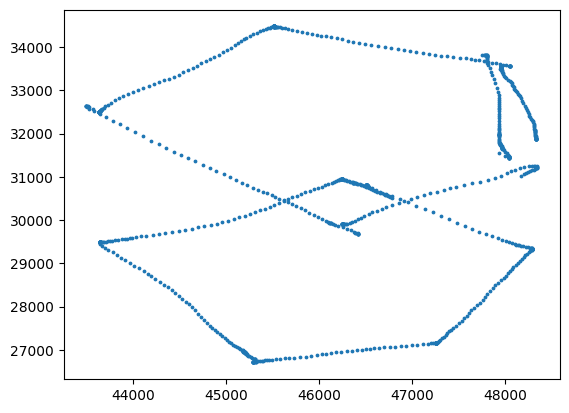

In [480]:
df = labeled_data_as_timeseries
subject_data = df[(df['homework']==1) & (df['pen_status']==1)].iloc[0]
plt.scatter(subject_data['x'], subject_data['y'], s=3 )


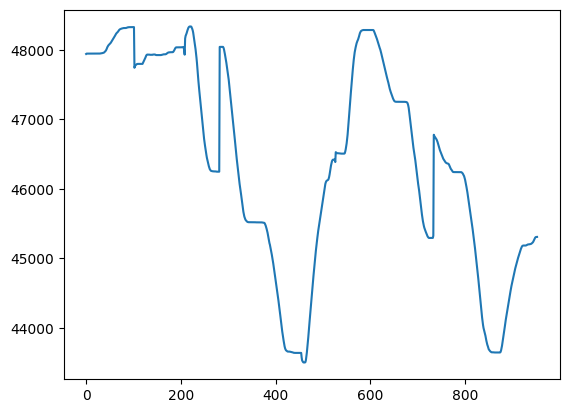

In [482]:
plt.plot(subject_data['x'])